# Introduction to Geospatial Raster and Vector Data with Python

[EGU24 Short Course 6.4](https://meetingorganizer.copernicus.org/EGU24/session/49444)

Ou Ku and Francesco Nattino

<img src="figs/netherlands-escience-center-logo-RGB.svg" alt="nlesc-logo" width=50%/>

---

Run this notebook live on Google Colab:

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="colab-badge" width=30%/>](https://colab.research.google.com/github/esciencecenter-digital-skills/2024-04-15-geospatial-python-EGU/blob/main/geospatial-python.ipynb)

If running on Google Colab, uncomment and run the following cell to install the Python dependencies:

In [1]:
# ! pip install -r https://raw.githubusercontent.com/esciencecenter-digital-skills/2024-04-15-geospatial-python-EGU/main/requirements.txt

---

In [2]:
# Access OpenStreetMap data
import osmnx as ox

# Access satellite data
import pystac_client
import odc.stac

# Vector data handling
import geopandas as gpd

# Raster data handling
import rioxarray

# Raster analyses
import xrspatial 

# Visualization
import matplotlib.pyplot as plt

## Define the Area of Interest

In [3]:
# Get polygon of Rhodes
rhodes = ox.geocode_to_gdf("Rhodes")

In [4]:
rhodes

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((27.68357 36.15271, 27.68378 36...",36.458283,35.876662,28.247628,27.683572,370997710,relation,452614,36.17253,27.919402,place,island,17,0.60392,island,Rhodes,"Rhodes, Aegean, Greece"


<Axes: >

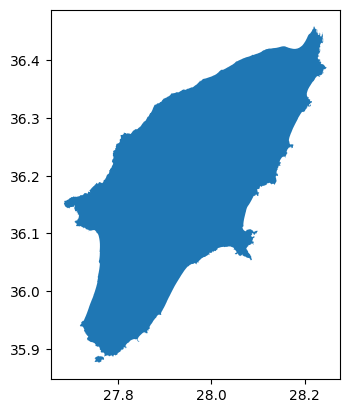

In [5]:
rhodes.plot()

In [6]:
rhodes.to_file("rhodes.gpkg")

## Search for Satellite Images

In [7]:
# Setup search client for STAC API
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)

In [8]:
# See collections with: list(client.get_collections())
collection = 'sentinel-2-c1-l2a'  # Sentinel-2, Level 2A
# Get the search geometry from the GeoDataFrame
polygon = rhodes.loc[0, 'geometry']

In [9]:
# Setup the search
search = client.search(
    collections=[collection],
    intersects=polygon,
    datetime='2023-07-01/2023-08-31', # date range 
    query=['eo:cloud_cover<10'] # cloud cover less than 10%
)

In [10]:
search.matched()

64

In [11]:
items = search.item_collection()

In [12]:
# Save search results
items.save_object('rhodes_sentinel-2.json')

## Open Satellite Images

In [13]:
# Load the search results as a xarray Dataset
ds = odc.stac.load(
    items,
    groupby="solar_day", # group the images within the same day
    bands=["red", "green", "blue", "nir", "scl"],
    resolution=40, # loading resolution
    chunks={'x': 2048, 'y':  2048}, # lazy loading with Dask
    bbox=polygon.bounds,
    dtype="uint16"
)

In [14]:
print(ds)

<xarray.Dataset> Size: 522MB
Dimensions:      (y: 1626, x: 1285, time: 25)
Coordinates:
  * y            (y) float64 13kB 4.036e+06 4.035e+06 ... 3.971e+06 3.97e+06
  * x            (x) float64 10kB 5.613e+05 5.613e+05 ... 6.126e+05 6.126e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
Data variables:
    red          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    green        (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    blue         (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    nir          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    scl          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>


In [15]:
ds_before = ds.sel(time="2023-07-13", method="nearest")
ds_after = ds.sel(time="2023-08-27", method="nearest")

In [16]:
def rgb_img(ds):
    """ 
    Generate RGB raster.
    
    Sentiel-2 L2A images are provided in Digital Numbers (DNs).
    Convert to reflectance by dividing by 10,000. Set reflectance
    equal to one for values >= 10,000.
    """
    ds_rgb = ds[["red", "green", "blue"]].to_array()
    ds_rgb = ds_rgb.clip(max=10000)
    return ds_rgb / 10_000

rgb_before = rgb_img(ds_before)
rgb_after = rgb_img(ds_after)

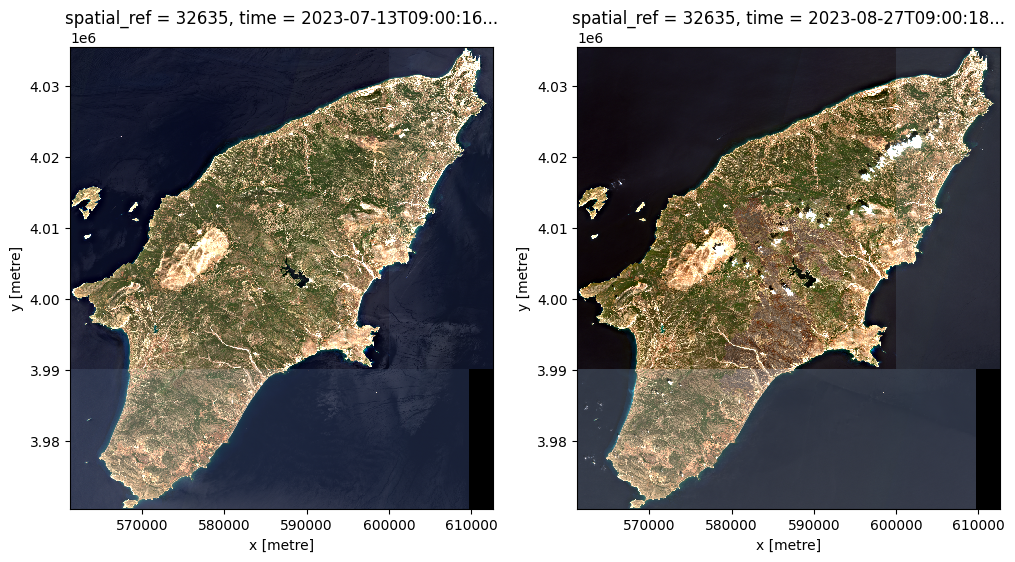

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Use "robust=True" to improve contrast
rgb_before.plot.imshow(ax=axs[0], robust=True) 
rgb_after.plot.imshow(ax=axs[1], robust=True)

## Raster Calculations

* Masking water and clouds
* Calculating NDVI (difference)

Sentinel 2 Level-2A [Scene Classification](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview):

| Label | Classification |
|-------| ---------------|
| 0	    | NO_DATA |
| 1	    | SATURATED_OR_DEFECTIVE |
| 2	    | CAST_SHADOWS |
| 3	    | CLOUD_SHADOWS |
| 4	    | VEGETATION |
| 5	    | NOT_VEGETATED |
| 6	    | WATER |
| 7	    | UNCLASSIFIED |
| 8	    | CLOUD_MEDIUM_PROBABILITY |
| 9	    | CLOUD_HIGH_PROBABILITY |
| 10    | THIN_CIRRUS |
| 11    | SNOW or ICE |

In [18]:
def mask_water_and_clouds(ds):
    """
    Mask water and clouds using the Sentinel-2
    scene classification map.
    """
    mask = ds["scl"].isin([3, 6, 8, 9, 10])
    return ds.where(~mask)

In [19]:
ds_masked = mask_water_and_clouds(ds)

Normalized Difference Vegetation Index (NDVI):

$$ NDVI = \frac{NIR - red}{NIR + red}$$

In [20]:
ndvi = (
    (ds_masked["nir"] - ds_masked["red"]) / 
    (ds_masked["nir"] + ds_masked["red"])
)

In [21]:
ndvi_before = ndvi.sel(time="2023-07-13", method="nearest")
ndvi_after = ndvi.sel(time="2023-08-27", method="nearest")

In [22]:
ndvi_diff = ndvi_after - ndvi_before

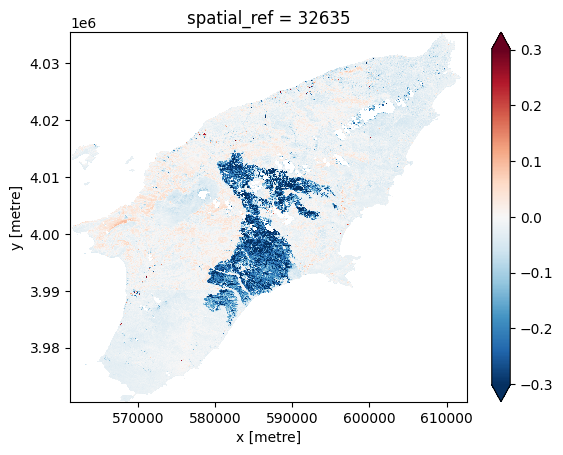

In [24]:
ndvi_diff.plot.imshow(robust=True)

If the NDVI drops significantly, we flag a vegetation damage. We use an arbitrary threshold here (0.4), for demonstration purposes.

In [25]:
burned_mask = ndvi_diff < -0.4

We visualize the burned area (in red) over the image taken after the wild fires.

In [26]:
# set 1. in red channel
rgb_after[0, :, :] = rgb_after[0, :, :].where(~burned_mask, other=1) 
# set 0. in green and blue channels
rgb_after[1:3, :, :] = rgb_after[1:3, :, :].where(~burned_mask, other=0)

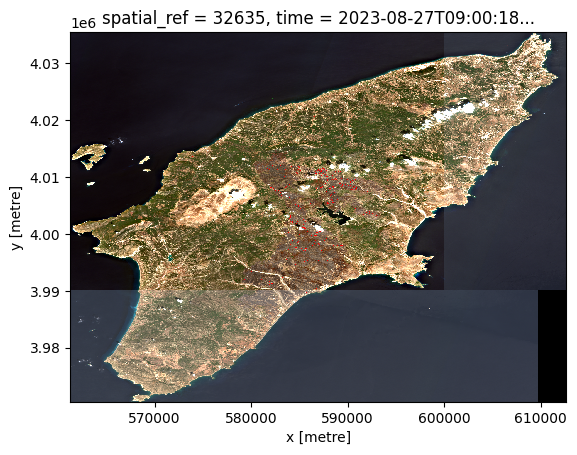

In [27]:
rgb_after.plot.imshow(robust=True)  

## Spatial Analysis

* Proximity analysis: how far are the main roads from the burned area?


In [28]:
# Download road network from OSM
highways = ox.features_from_place(
    "Rhodes",
    tags={
        "highway":[
            "primary", 
            "secondary", 
            "tertiary",
        ]
    }
)

In [30]:
highways.head()

highway                       name  \
element_type osmid                                            
way          16227449  secondary           Κάλαθος - Λάρδος   
             23857290  secondary                     Αθήνας   
             23857299   tertiary  Αφάντου - Παραλία Αφάντου   
             23857798  secondary          Εθνάρχου Μακαρίου   
             23886864  secondary                     Περνού   

                                                                geometry  \
element_type osmid                                                         
way          16227449  LINESTRING (28.05782 36.11255, 28.05777 36.112...   
             23857290  LINESTRING (28.15816 36.29237, 28.15804 36.292...   
             23857299  LINESTRING (28.17677 36.28603, 28.17512 36.287...   
             23857798  LINESTRING (28.16234 36.29545, 28.16222 36.295...   
             23886864  LINESTRING (28.16264 36.29141, 28.16264 36.291...   

                                   name:en maxspeed access  \
element_type osmid                                           
way          16227449                  NaN       50    NaN   
             23857290              Athinas      NaN    NaN   
             23857299                  NaN      NaN    NaN   
             23857798  Ethnarchou Makariou      NaN    NaN   
             23886864               Pernou      NaN    NaN   

                                   name:de                    name:el  ref  \
element_type osmid                                                           
way          16227449                  NaN                        NaN  NaN   
             23857290                  NaN                        NaN  NaN   
             23857299                  NaN  Αφάντου - Παραλία Αφάντου  NaN   
             23857798  Ethnarchou Makariou                        NaN  NaN   
             23886864               Pernou                        NaN  NaN   

                                  int_name  ... turn:lanes:forward  \
element_type osmid                          ...                      
way          16227449                  NaN  ...                NaN   
             23857290              Athinas  ...                NaN   
             23857299                  NaN  ...                NaN   
             23857798  Ethnarchou Makariou  ...                NaN   
             23886864               Pernou  ...                NaN   

                      lanes:backward lanes:forward placement:forward  \
element_type osmid                                                     
way          16227449            NaN           NaN               NaN   
             23857290            NaN           NaN               NaN   
             23857299            NaN           NaN               NaN   
             23857798            NaN           NaN               NaN   
             23886864            NaN           NaN               NaN   

                      placement area sidewalk:right destination  \
element_type osmid                                                
way          16227449       NaN  NaN            NaN         NaN   
             23857290       NaN  NaN            NaN         NaN   
             23857299       NaN  NaN            NaN         NaN   
             23857798       NaN  NaN            NaN         NaN   
             23886864       NaN  NaN            NaN         NaN   

                      destination:lang:en check_date:lit  
element_type osmid                                        
way          16227449                 NaN            NaN  
             23857290                 NaN            NaN  
             23857299                 NaN            NaN  
             23857798                 NaN            NaN  
             23886864                 NaN            NaN  

[5 rows x 54 columns]

In [31]:
# compute (horizontal) distance from burned area 
distance = xrspatial.proximity(burned_mask)

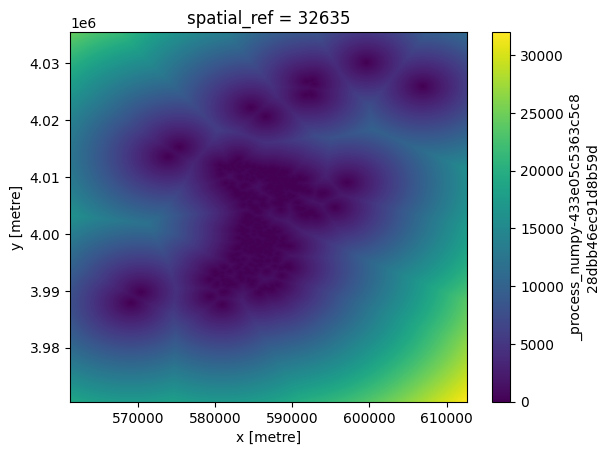

In [32]:
distance.plot.imshow()

In [33]:
highways_buffer = highways \
    .to_crs(burned_mask.rio.crs) \
    .buffer(50)  # 50m buffer around the roads

In [35]:
highways_buffer.head()

element_type  osmid   
way           16227449    POLYGON ((595245.628 3996919.334, 595242.555 3...
              23857290    POLYGON ((603734.479 4017325.585, 603733.866 4...
              23857299    POLYGON ((605499.357 4016384.271, 605481.244 4...
              23857798    POLYGON ((604268.978 4017155.490, 604267.841 4...
              23886864    POLYGON ((604331.176 4017312.025, 604327.734 4...
dtype: geometry

In [36]:
distance_clip = distance.rio.clip(highways_buffer)

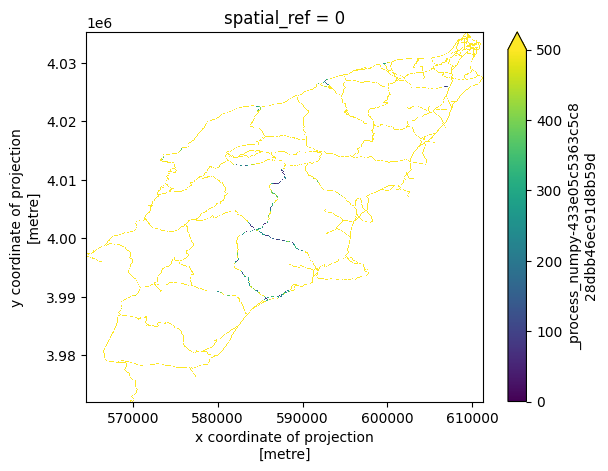

In [37]:
# Visualize roads, focusing on distances <500m from the fires
distance_clip.plot.imshow(vmax=500)  

## Links

* [GitHub Repository](https://github.com/esciencecenter-digital-skills/2024-04-15-geospatial-python-EGU) (leave us [feedback](https://github.com/esciencecenter-digital-skills/2024-04-15-geospatial-python-EGU/issues/new/choose)!)
* Lesson Material: [Introduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/)
* Netherlands eScience Center [Newsletters](http://eepurl.com/dtjzwP)